In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay


In [3]:
DATA_PATH = "S05-hw-dataset.csv"  # если файл лежит рядом с ноутбуком
df = pd.read_csv(DATA_PATH)
df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [4]:
df.info()
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

,count,mean,std,min,25%,50%,75%,max
client_id,3000.0,1500.500000,866.169729,1.000000,750.750000,1500.500000,2250.250000,3000.000000
age,3000.0,45.059667,14.192883,21.000000,33.000000,45.000000,57.000000,69.000000
income,3000.0,69658.992000,24742.235182,15000.000000,52641.750000,69784.500000,85874.250000,156351.000000
years_employed,3000.0,19.577667,11.381497,0.000000,10.000000,20.000000,29.000000,39.000000
credit_score,3000.0,649.285333,69.955852,402.000000,604.000000,647.000000,697.000000,850.000000
debt_to_income,3000.0,0.284065,0.161112,0.006147,0.157796,0.261726,0.388886,0.878343
num_credit_cards,3000.0,3.494667,2.289917,0.000000,1.000000,3.000000,6.000000,7.000000
num_late_payments,3000.0,6.869333,4.291278,0.000000,3.000000,7.000000,10.000000,14.000000
has_mortgage,3000.0,0.495000,0.500058,0.000000,0.000000,0.000000,1.000000,1.000000
has_car_loan,3000.0,0.501333,0.500082,0.000000,0.000000,1.000000,1.000000,1.000000


In [5]:
target_col = "default"
df[target_col].value_counts(dropna=False)

default
0    1769
1    1231
Name: count, dtype: int64

In [6]:
(df[target_col].value_counts(normalize=True) * 100).round(2)

default
0    58.97
1    41.03
Name: proportion, dtype: float64

In [7]:
y = df[target_col]
X = df.drop(columns=[target_col, "client_id"], errors="ignore")

X.shape, y.shape

((3000, 15), (3000,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((2400, 15), (600, 15))

In [9]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_dummy = roc_auc_score(y_test, y_proba_dummy)

acc_dummy, roc_dummy

(0.59, 0.5)

In [10]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, random_state=42))
])

param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0]
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_

({'model__C': 10.0}, 0.8606590016322577)

In [11]:
best_model = grid.best_estimator_

y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_proba_lr)

acc_lr, roc_lr

(0.8, 0.8756373156951908)

In [12]:
pd.DataFrame([
    {"model": "Dummy(most_frequent)", "accuracy": acc_dummy, "roc_auc": roc_dummy},
    {"model": "LogReg+Scaler (best C)", "accuracy": acc_lr, "roc_auc": roc_lr},
])

,model,accuracy,roc_auc
0,Dummy(most_frequent),0.59,0.500000
1,LogReg+Scaler (best C),0.80,0.875637


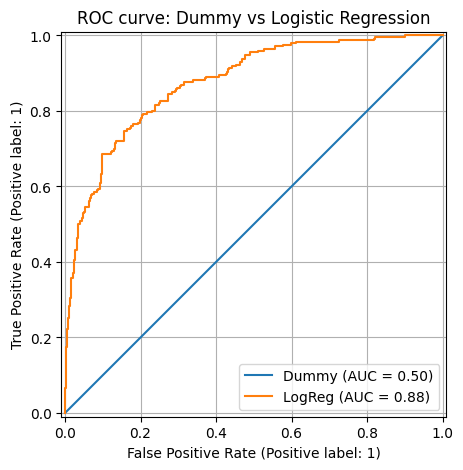

In [13]:
os.makedirs("figures", exist_ok=True)

fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_dummy, name="Dummy", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="LogReg", ax=ax)
ax.set_title("ROC curve: Dummy vs Logistic Regression")
ax.grid(True)

fig.savefig("figures/roc_curve.png", dpi=150, bbox_inches="tight")
plt.show()

### Краткий отчёт по HW05 (Dummy vs Logistic Regression)

**Данные и постановка задачи.**  
Загружен датасет `S05-hw-dataset.csv`. Таргет — `default` (1 = дефолт, 0 = нет дефолта). Признак `client_id` исключён из матрицы признаков, так как это идентификатор и он не должен влиять на модель.

**Первичный анализ.**  
Просмотрены `head()`, `info()`, `describe()`. Также проанализировано распределение таргета `default` (по количеству и доле классов), чтобы понять, есть ли дисбаланс.

**Подготовка выборок.**  
Данные разделены на `train/test` с фиксированным `random_state=42`, параметром `test_size=0.2` и `stratify=y`, чтобы сохранить пропорции классов в обеих выборках.

**Бейзлайн.**  
Построена baseline-модель `DummyClassifier(strategy="most_frequent")`. На тестовой выборке посчитаны метрики **accuracy** и **ROC-AUC**. Бейзлайн даёт ориентир “качества без обучения” и помогает понять, есть ли реальный выигрыш у более сложной модели.

**Логистическая регрессия.**  
Построена модель логистической регрессии в виде `Pipeline` (масштабирование `StandardScaler` + `LogisticRegression`). Выполнен подбор гиперпараметра регуляризации `C` (через `GridSearchCV`). После выбора лучшего `C` модель оценена на тестовой выборке по **accuracy** и **ROC-AUC**.

**Сравнение и выводы.**  
Сравнение показало, какая модель лучше по двум критериям:
- **accuracy** — доля правильных ответов;  
- **ROC-AUC** — качество ранжирования по вероятностям (особенно важно при дисбалансе классов).  

Если логистическая регрессия превосходит `DummyClassifier` по ROC-AUC (и желательно по accuracy), то модель действительно учится полезным закономерностям. Если же улучшение минимально, то стоит проверить качество признаков, обработку категориальных/пропусков и рассмотреть другие модели или настройки.

**Визуализация.**  
Построена ROC-кривая для сравнения `DummyClassifier` и логистической регрессии. График сохранён в `homeworks/HW05/figures/roc_curve.png`.